#  4 PCA

## 4.1 Explained Variance and Lossy Reconstruction

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  
])

train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

X_train = torch.stack([img for img, label in train_set])
y_train = torch.tensor([label for _, label in train_set])

X_test = torch.stack([img for img, label in test_set])
y_test = torch.tensor([label for _, label in test_set])


num_classes = 10
samples_per_class = 100  
selected_indices = []

for c in range(num_classes):
    class_indices = torch.where(y_train == c)[0]  
    selected_indices.extend(class_indices[torch.randperm(len(class_indices))[:samples_per_class]].tolist())

X_sampled = X_train[selected_indices]
y_sampled = y_train[selected_indices]

print("Class distribution:", dict(Counter(y_sampled.numpy())))
print("Sampled data shape:", X_sampled.shape)

X_sampled = X_sampled.numpy()
y_sampled = y_sampled.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

Class distribution: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}
Sampled data shape: torch.Size([1000, 784])


In [28]:
import matplotlib.pyplot as plt
def pca(X,n_comp):

    if isinstance(X, torch.Tensor):
        X = X.numpy()

    X_meaned = X
    
    #covariance matrix,eigenvalues & eigenvectors
    covar_matrix = np.cov(X_meaned,rowvar=False)
    e_values,e_vectors = np.linalg.eigh(covar_matrix)

    #sorting eigenvalues-descending order
    sort_values = np.argsort(e_values)[::-1]
    e_values = e_values[sort_values]
    e_vectors = e_vectors[:,sort_values]

    select_vectors = e_vectors[:,:n_comp]
    X_reduced = np.dot(X_meaned,select_vectors)

    #explained variance
    explained_variance_ratio = np.sum(e_values[:n_comp]) / np.sum(e_values)

    return X_reduced,select_vectors,X_meaned, explained_variance_ratio


In [29]:
X_pca_500,_,_,_ = pca(X_sampled, 500)
X_pca_300,_,_,_ = pca(X_sampled, 300)
X_pca_150,_,_,_= pca(X_sampled, 150)
X_pca_30,_,_,_  = pca(X_sampled, 30)

print("Original Shape:", X_sampled.shape)  
print("Reduced Shape (500D):", X_pca_500.shape)  
print("Reduced Shape (300D):", X_pca_300.shape)  
print("Reduced Shape (150D):", X_pca_150.shape) 
print("Reduced Shape (30D):", X_pca_30.shape)    


Original Shape: (1000, 784)
Reduced Shape (500D): (1000, 500)
Reduced Shape (300D): (1000, 300)
Reduced Shape (150D): (1000, 150)
Reduced Shape (30D): (1000, 30)


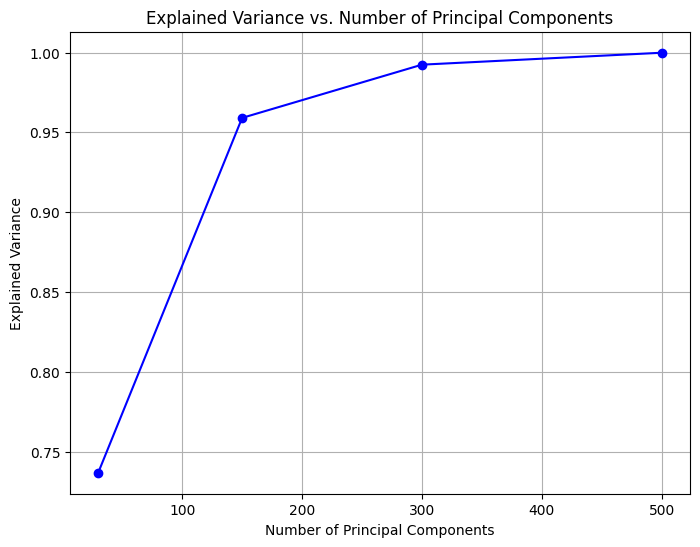

In [30]:
n_comp = [500, 300, 150, 30]
explained_variances = []

for n in n_comp:
    _,_,_, variance = pca(X_sampled, n)
    explained_variances.append(variance)


plt.figure(figsize=(8, 6))
plt.plot(n_comp, explained_variances, marker='o', linestyle='-', color='b')

plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

### Observations:
- The curve typically shows a steep rise at the beginning and then flattens out. Beyond the 'elbow' point adding more components give diminishing returns.
- 95% variance is captured within 200 components and it approached to 100% as more components are added.

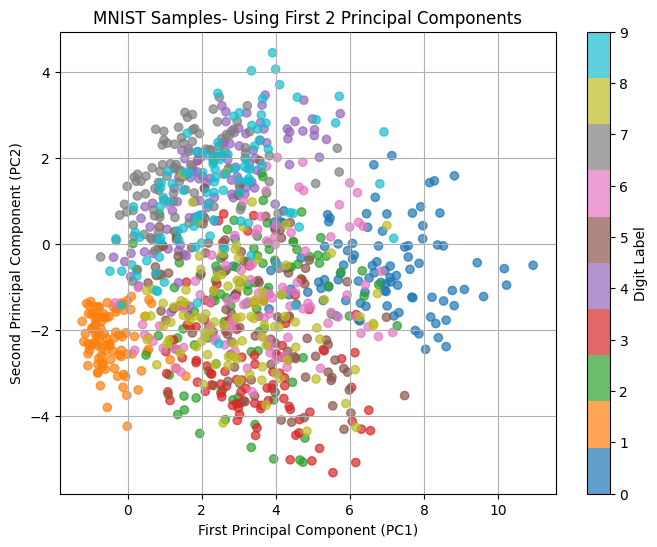

In [31]:
X_pca_2, _ ,_,_= pca(X_sampled, 2)

plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y_sampled, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Digit Label")

plt.xlabel("First Principal Component (PC1)")
plt.ylabel("Second Principal Component (PC2)")
plt.title("MNIST Samples- Using First 2 Principal Components")
plt.grid()
plt.show()

### Observations:
- The PCA scatter plot of MNIST shows clusters for different digits,much overlap exists, particularly among visually similar ones like 4 and 9 or 3 and 8.
- Since PCA is a linear technique, reducing 784 dimensions to just 2 captures only a small fraction of the variance, leading to some loss of information.
- The first principal component likely represents global shape features such as size and thickness, while the second captures finer variations like stroke style. However, given the complex, non-linear nature of digit structures, PCA alone does not fully separate all classes of digits

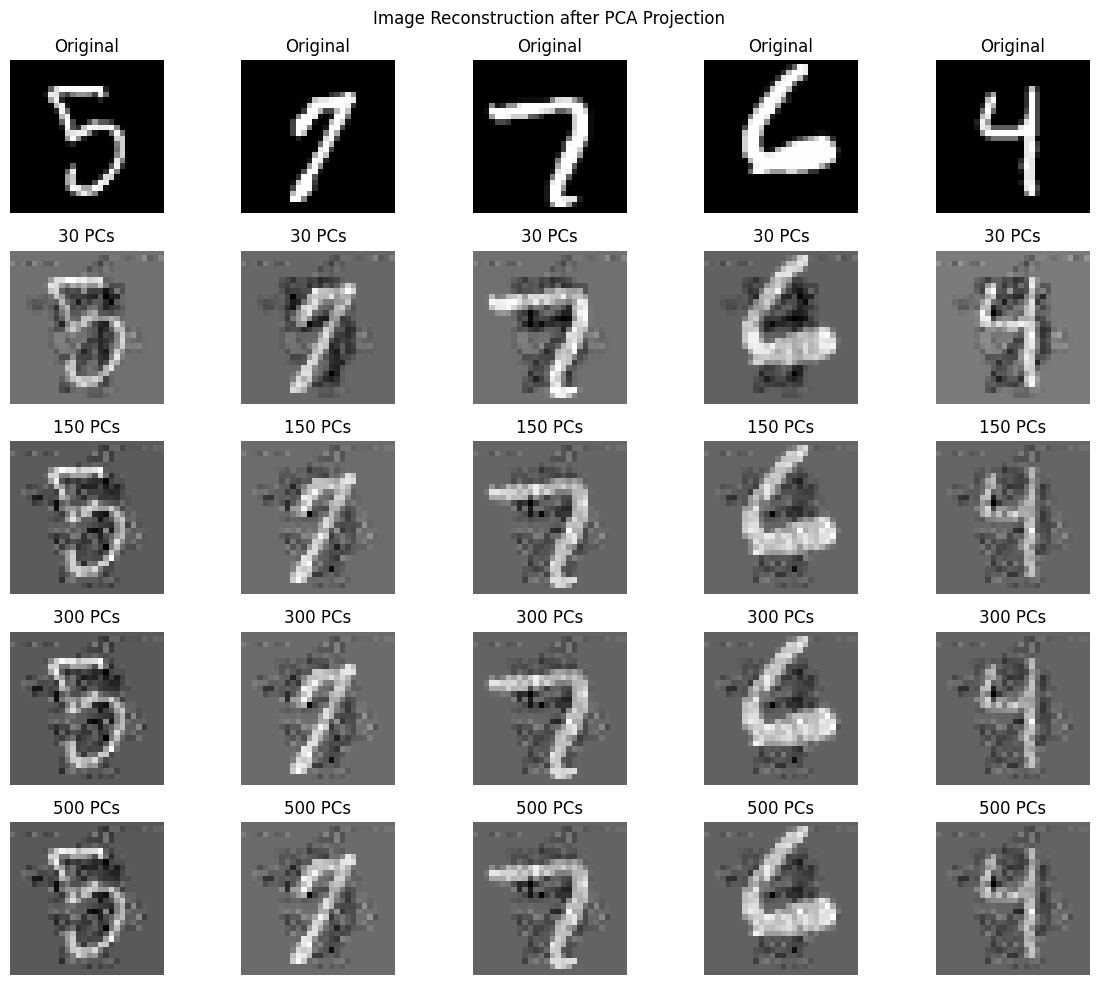

In [32]:

import matplotlib.pyplot as plt

np.random.seed(42)
indices = np.random.choice(len(X_sampled), 5, replace=False)
selected_images = X_sampled[indices] 

pca_dim = [30, 150, 300, 500]

fig, axes = plt.subplots(len(pca_dim) + 1, 5, figsize=(12, 10))

# Plot-original images
for i in range(5):
    axes[0, i].imshow(selected_images[i].reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

# PCA
for row, n_comp in enumerate(pca_dim, start=1):
    X_reduced, eigenvectors, X_mean,_ = pca(selected_images, n_comp)

    X_reconstructed = np.dot(X_reduced, eigenvectors.T) 

    # Plot reconstructed images
    for i in range(5):
        axes[row, i].imshow(X_reconstructed[i].reshape(28, 28), cmap="gray")
        axes[row, i].axis("off")
        axes[row, i].set_title(f"{n_comp} PCs")


plt.suptitle("Image Reconstruction after PCA Projection")
plt.tight_layout()
plt.show()


### Observations:
- Higher Dimensionality Retains More Details: When using a low number of principal components (PCs), the reconstructed images appear blurry and lose fine details. Only the general shape and structure in the images are preserved.
- As the number of PCs increases, more high-frequency components, such as edges, textures, and finer details, are retained, making the reconstruction sharper and closer to the original image.
- Noise Reduction in low dimensions: PCA effectively removes noise when using fewer principal components. This happens because random noise is usually distributed across many dimensions, while the main image features are concentrated in a few principal components. As a result, using a small number of PCs filters out high-frequency noise, leading to a smoother and cleaner output.

## 4.2 Classification Performance with vs without dimensionality reduction

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from collections import Counter

# MNIST 
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

X_train = torch.stack([train_set[i][0] for i in range(len(train_set))]).numpy()
y_train = np.array([train_set[i][1] for i in range(len(train_set))])
X_test = torch.stack([test_set[i][0] for i in range(len(test_set))]).numpy()
y_test = np.array([test_set[i][1] for i in range(len(test_set))])

#40K random samples
np.random.seed(42)
train_indices = np.random.choice(len(X_train), 40000, replace=False)
X_train_sampled, y_train_sampled = X_train[train_indices], y_train[train_indices]

# Normalizing data
scaler = StandardScaler()
X_train_sampled = scaler.fit_transform(X_train_sampled)
X_test = scaler.transform(X_test)

#MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', solver='adam',
                    batch_size=64, max_iter=100, random_state=42, early_stopping=True)

mlp.fit(X_train_sampled, y_train_sampled)
y_pred = mlp.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:}")
print(f"Precision: {precision:}")
print(f"Recall: {recall:}")


Accuracy: 0.9748
Precision: 0.9748949995190908
Recall: 0.9748


In [55]:
# PCA dimensions
pca_components = [500, 300, 150, 30]
results = {}

for n_comp in pca_components:
    print(f"\nPCA with {n_comp} components")

    X_train_pca, select_vectors, explained_variance_ratio = pca(X_train_sampled, n_comp)
    X_test_pca = np.dot(X_test - np.mean(X_train_sampled, axis=0), select_vectors)

    # MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', solver='adam',
                        batch_size=64, max_iter=100, random_state=42, early_stopping=True)

    mlp.fit(X_train_pca, y_train_sampled)
    y_pred = mlp.predict(X_test_pca)

    #metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    results[n_comp] = (accuracy, precision, recall)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")


print("\nResults:")
for n, (acc, prec, rec) in results.items():
    print(f"PCA {n} Components -> Accuracy: {acc:}, Precision: {prec:}, Recall: {rec:}")



PCA with 500 components
Accuracy: 0.9625
Precision: 0.9626
Recall: 0.9625

PCA with 300 components
Accuracy: 0.9728
Precision: 0.9729
Recall: 0.9728

PCA with 150 components
Accuracy: 0.9740
Precision: 0.9740
Recall: 0.9740

PCA with 30 components
Accuracy: 0.9649
Precision: 0.9651
Recall: 0.9649

Results:
PCA 500 Components -> Accuracy: 0.9625, Precision: 0.9626419002674187, Recall: 0.9625
PCA 300 Components -> Accuracy: 0.9728, Precision: 0.9728527190820487, Recall: 0.9728
PCA 150 Components -> Accuracy: 0.974, Precision: 0.974042412847176, Recall: 0.974
PCA 30 Components -> Accuracy: 0.9649, Precision: 0.9651021914909623, Recall: 0.9649


### Observations:
- The highest accuracy (0.9740), precision (0.9740), and recall (0.9740) are observed when using 150 principal components (PCs). It suggests that 150 PCs capture the most important features for classification while filtering out unnecessary noise.
- With 300 PCs, performance slightly drops to 0.9728, and with 500 PCs, it further declines to 0.9625. This may be due to overfitting: Higher dimensions may reintroduce noise and capture irrelevant variations in the data, classifier may start memorizing small details rather than general patterns, reducing generalization.
- With only 30 PCs, performance decreases to 0.9649, this is likely because the lower number of PCs cannot retain enough important features, leading to loss of discriminative information and hence classifier struggles due to missing essential patterns, causing reduced accuracy

##  4.3 Report


### How PCA Helps Mitigate the Curse of Dimensionality
The curse of dimensionality refers to problems that arise as the number of features (dimensions) in a dataset increases, such as:
- Increased sparsity: High-dimensional data becomes sparse, making distance-based methods (e.g., k-NN) less effective.
- Overfitting: More features mean a higher risk of capturing noise rather than meaningful patterns.
- Computational cost: More dimensions lead to increased storage and processing requirements.
#### PCA helps mitigate this by:
-  Reducing Redundant Features: PCA projects data onto a lower-dimensional space while retaining as much variance (information) as possible.
-  Improving Generalization: By removing noise and irrelevant variations, PCA helps machine learning models generalize better. and also reduced computational costs.

### When PCA Might Not Be Effective in High-Dimensional Spaces
- PCA is a linear transformation, meaning it assumes that data variations are best captured using linear combinations of features. If the data has non-linear structures, PCA may fail to capture meaningful patterns.
- PCA prioritizes features with the most variance, assuming they carry the most useful information. If low-variance features are critical for classification (example: medical diagnosis with rare but important markers), PCA might discard them.
- PCA works best when data follows a Gaussian (normal) distribution. If data is skewed or multimodal, PCA’s assumption of principal components being the best representation may not hold.
- In cases like text processing (example: TF-IDF or bag-of-words representations), high-dimensional sparsity is meaningful.
PCA may remove essential word frequency information.

### PCA’s Assumption Fails
1. Example 1: Identifying Rare but Important Features (Medical Diagnosis)
- Consider a medical dataset where we predict a rare disease. Some low-variance biomarkers might be highly predictive of the disease, while high-variance features like patient weight or height may be irrelevant.
PCA would discard the low-variance but critical biomarkers, reducing classification performance.

2. Example 2: Separating Two Intersecting Classes (Classification Problem)
- Imagine a binary classification task where two classes are separable along a low-variance direction. PCA may select the high-variance direction ignoring class labels, which may not align with best decision boundary, leading to poor classification.

3. Example 3: Text Data (Sparse High-Dimensional Features)
- In natural language processing (NLP), words in a document are represented using high-dimensional sparse vectors (TF-IDF, bag-of-words, etc.).
PCA might remove rare but contextually meaningful words, degrading topic modeling or classification as high variance words may be common stopwords, while low variance words carry domain-specific meaning.